# Importing Required Libraies

In [1]:
!pip3 install transformers

In [2]:
import numpy as np # for numerical computation
import pandas as pd # for data analysis and manipulation

### For data downloading, loading, transformation and DL model download, creating and training
import torch
import torch.nn as NN
from torchvision import transforms, models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Downloading Dataset

Datset URL : https://www.kaggle.com/datasets/hassanamin/atis-airlinetravelinformationsystem?resource=download&select=atis_intents.csv

# Device Settings

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Loadin Dataset

In [5]:
# loading raw dataset as training and testing
def read_data(path):
    df = pd.read_csv(path, names=['target', 'data'])
    class_labels = df['target']
    data = df['data']

    return [data, class_labels]



train_data_path = 'archive/atis_intents_train.csv'
test_data_path = 'archive/atis_intents_test.csv'

test_dataset = read_data(test_data_path)
train_dataset = read_data(train_data_path)

In [6]:
# encoding class values
def class_encoder(labels):
    labels_ = set(labels)
    encoder = dict()
    reverse_encoder = dict()

    for i, label in enumerate(labels_):
        encoder[label] = i
        reverse_encoder[i] = label

    return encoder, reverse_encoder


encoder, reverse_encoder = class_encoder(train_dataset[1])
encoder

{'atis_airfare': 0,
 'atis_flight': 1,
 'atis_flight_time': 2,
 'atis_aircraft': 3,
 'atis_airline': 4,
 'atis_quantity': 5,
 'atis_abbreviation': 6,
 'atis_ground_service': 7}

In [7]:
class CustomDataset(Dataset):
    def __init__(self, data, encoder, tokenizer, max_seq):
        self.data = data[0] # sentences
        self.classes = data[1] # labels
        self.encoder = encoder
        self.tokenizer = tokenizer
        self.max_seq = max_seq


    def __len__(self):
        return len(self.classes)

    def __getitem__(self, index):
        text = self.data[index]

        #tokenize the text using tokenizer
        tokens = self.tokenizer.encode_plus(text, max_length=self.max_seq, padding='max_length', truncation=True, return_tensors='pt')

        # get the input ids and convert them to numpy array
        input_ids = tokens['input_ids'][0].numpy()

        # converting label to tensor
        label = torch.tensor(self.encoder[self.classes[index]], dtype=torch.long)

        return input_ids, label

train_data = CustomDataset(train_dataset, encoder, tokenizer, 300)
test_data = CustomDataset(test_dataset, encoder, tokenizer, 300)

In [8]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Defining Hyperparameters and Making Model

In [9]:
class IntentClassifier(NN.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(IntentClassifier, self).__init__()
        self.fc1 = NN.Linear(input_dim, hidden_dim)
        self.fc2 = NN.Linear(hidden_dim, hidden_dim)
        self.fc3 = NN.Linear(hidden_dim, hidden_dim)
        self.fc4 = NN.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (batch_size, input_dim)
        x = self.fc1(x)
        x = NN.functional.relu(x)
        # x shape: (batch_size, hidden_dim)
        x = self.fc2(x)
        x = NN.functional.relu(x)
        x = self.fc3(x)
        x = NN.functional.relu(x)
        # x shape: (batch_size, hidden_dim)
        x = self.fc4(x)
        # x shape: (batch_size, output_dim)
        return x

In [10]:
#define hyperparameters
num_epochs = 50
input_ = 300
hidden = 128
output = 8
learning_rate = 0.001

#instantiate the model
model = IntentClassifier(input_, hidden, output).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = NN.CrossEntropyLoss()

# Training and Testing Models Accuracy

In [11]:
LOSS = []

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = torch.tensor(inputs).float().to(device)
        # Move tensors to device
        labels = labels.to(device)
        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    LOSS.append(loss.item())

/var/folders/h7/ymk6fg6n73d2_5kym98n911c0000gn/T/ipykernel_48234/173307907.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).float().to(device)


Epoch [1/50], Step [152/152], Loss: 0.0664
Epoch [2/50], Step [152/152], Loss: 0.1545
Epoch [3/50], Step [152/152], Loss: 0.8575
Epoch [4/50], Step [152/152], Loss: 2.1475
Epoch [5/50], Step [152/152], Loss: 0.1007
Epoch [6/50], Step [152/152], Loss: 1.6810
Epoch [7/50], Step [152/152], Loss: 0.6843
Epoch [8/50], Step [152/152], Loss: 0.1620
Epoch [9/50], Step [152/152], Loss: 1.4042
Epoch [10/50], Step [152/152], Loss: 0.0791
Epoch [11/50], Step [152/152], Loss: 1.7870
Epoch [12/50], Step [152/152], Loss: 0.1659
Epoch [13/50], Step [152/152], Loss: 0.3122
Epoch [14/50], Step [152/152], Loss: 3.3464
Epoch [15/50], Step [152/152], Loss: 0.1998
Epoch [16/50], Step [152/152], Loss: 2.8797
Epoch [17/50], Step [152/152], Loss: 1.4624
Epoch [18/50], Step [152/152], Loss: 0.0856
Epoch [19/50], Step [152/152], Loss: 0.4439
Epoch [20/50], Step [152/152], Loss: 0.2135
Epoch [21/50], Step [152/152], Loss: 0.4491
Epoch [22/50], Step [152/152], Loss: 1.3131
Epoch [23/50], Step [152/152], Loss: 1.33

In [12]:
# saving trained model
torch.save(model.state_dict(), 'intentClassifier.pth')

In [13]:
#testing model
# Create an empty list to store the predictions and targets
predictions = []
targets = []

# Set the model to evaluation mode
model.eval()

# Loop over the batches in the test data
with torch.no_grad():
    for input_, labels in test_loader:
        # Forward pass
        input_ = torch.tensor(input_).float().to(device)
        output = model(input_)

        # Compute the predicted class and append it to the predictions list
        _, predicted = torch.max(output.data, 1)
        predictions.extend(predicted.tolist())

        # Append the targets to the targets list
        targets.extend(labels)

# Compute the accuracy

print(len(predictions), len(targets))
correct = sum([1 if predictions[i] == targets[i] else 0 for i in range(len(targets))])
total = len(targets)
accuracy = 100 * correct / total

# Print the accuracy
print('Accuracy: {:.2f}%'.format(accuracy))


/var/folders/h7/ymk6fg6n73d2_5kym98n911c0000gn/T/ipykernel_48234/3296478908.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(input_).float().to(device)


800 800
Accuracy: 81.38%


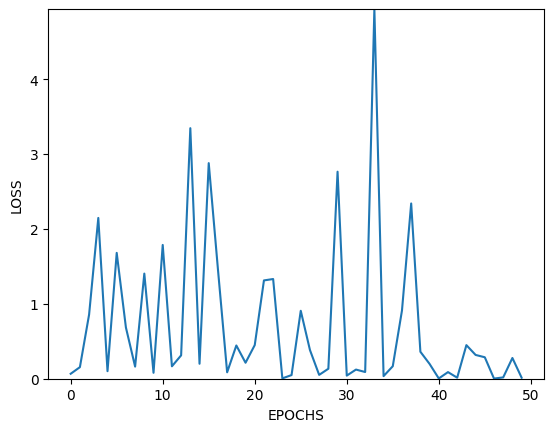

In [14]:
# printing results
plt.plot(np.arange(50), LOSS)
plt.xlabel("EPOCHS")
plt.ylabel("LOSS")
plt.ylim(0, max(LOSS))
plt.show()

# Predicting Text

In [ ]:
sentence = input("> ")

In [ ]:
data = [[sentence], ['atis_flight']]

data = CustomDataset(data, encoder, tokenizer, 300)
data = DataLoader(data)

model.eval()
# Loop over the batches in the test data
with torch.no_grad():
    for (inputs, labels) in data:
        # Forward pass
        inputs = torch.tensor(inputs).float().to(device)
        output = model(inputs)

        # Compute the predicted class and append it to the predictions list
        _, predicted = torch.max(output.data, 1)


print(f"Intention is {reverse_encoder[int(predicted.cpu())]}")